In [12]:
!pip uninstall -q tensorboard tb-nightly -y
!pip install -q tb-nightly

In [13]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c plant-pathology-2020-fgvc7

mkdir: cannot create directory ‘/root/.kaggle’: File exists
plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!pip install -q albumentations

In [15]:
import numpy as np 
import pandas as pd
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
# from scipy.special import softmax
# import cv2
# from transformers import get_cosine_schedule_with_warmup
# from transformers import AdamW
from tqdm.notebook import tqdm
from albumentations import *
from albumentations.pytorch import ToTensor

In [16]:
!unzip -q plant-pathology-2020-fgvc7.zip -d Plant_Pathology;

replace Plant_Pathology/images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Plant_Pathology/images/Test_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [17]:
data_dir = '/content/Plant_Pathology'
img_dir = data_dir + '/images'

train = pd.read_csv('/content/Plant_Pathology/train.csv')
test = pd.read_csv('/content/Plant_Pathology/test.csv')

In [18]:
def open_image(path):
  with open(path, 'rb') as f:
    img = Image.open(f);
    img_array = np.array(img)
    print(img_array.shape)
    return img.convert('RGB')
    # return a

def matplot_img(path):
  with open(path, 'rb') as f:
    img = Image.open(f);
    img_array = np.array(img)
    print(img_array.shape)
    return plt.imshow(img)

In [19]:
def get_image_path(path):
  return img_dir + '/' + path + '.jpg'

# def get_image_path_npy(path):
#   return img_dir + '/' + path + '.npy'

In [20]:
train = pd.read_csv('/content/Plant_Pathology/train.csv')
test = pd.read_csv('/content/Plant_Pathology/test.csv')


# train_labels = train.loc[:, 'healthy':'scab']
# train_paths = train.image_path
# test_paths = test.image_path

train['image_path'] = get_image_path(train['image_id'])
test['image_path'] = get_image_path(test['image_id'])
train_col = train.drop(['image_id', 'image_path'], axis=1)
train_path = train.image_path
test_path = test.image_path

In [21]:
train.head(10)

,image_id,healthy,multiple_diseases,rust,scab,image_path
0,Train_0,0,0,0,1,/content/Plant_Pathology/images/Train_0.jpg
1,Train_1,0,1,0,0,/content/Plant_Pathology/images/Train_1.jpg
2,Train_2,1,0,0,0,/content/Plant_Pathology/images/Train_2.jpg
3,Train_3,0,0,1,0,/content/Plant_Pathology/images/Train_3.jpg
4,Train_4,1,0,0,0,/content/Plant_Pathology/images/Train_4.jpg
5,Train_5,1,0,0,0,/content/Plant_Pathology/images/Train_5.jpg
6,Train_6,0,1,0,0,/content/Plant_Pathology/images/Train_6.jpg
7,Train_7,0,0,0,1,/content/Plant_Pathology/images/Train_7.jpg
8,Train_8,0,0,0,1,/content/Plant_Pathology/images/Train_8.jpg
9,Train_9,1,0,0,0,/content/Plant_Pathology/images/Train_9.jpg


In [23]:
train_label = train.melt(id_vars=['image_id', 'image_path'])
train_label = train_label[train_label['value'] == 1]
train_label['id'] = [int(i[1]) for i in train_label['image_id'].str.split('_')]
train_label = train_label.sort_values('id').reset_index()
train['label'] = train_label['variable']
train = train[train.columns[[0, 5, 1, 2, 3, 4, 6]]]
train.head()

,image_id,image_path,healthy,multiple_diseases,rust,scab,label
0,Train_0,/content/Plant_Pathology/images/Train_0.jpg,0,0,0,1,scab
1,Train_1,/content/Plant_Pathology/images/Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2,/content/Plant_Pathology/images/Train_2.jpg,1,0,0,0,healthy
3,Train_3,/content/Plant_Pathology/images/Train_3.jpg,0,0,1,0,rust
4,Train_4,/content/Plant_Pathology/images/Train_4.jpg,1,0,0,0,healthy


In [24]:
# train_label = train.melt(id_vars=['image_id', 'image_path'])
# train_label = train_label[train_label['value'] == 1]
# train_label['id'] = [int(i[1]) for i in train_label['image_id'].str.split('_')]
# train_label = train_label.sort_values('id').reset_index()
# train['label'] = train_label['variable']
# train = train[train.columns[[0, 5, 1, 2, 3, 4, 6]]]
# print(train_label.shape)
# train.head(10)

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_enc = le.fit_transform(train['label'])
train['label_enc'] = label_enc
# train.drop(['label_encoded'], axis=1, inplace=True)
# label_name = list(label_encoded.classes_)
train.head(10)

,image_id,image_path,healthy,multiple_diseases,rust,scab,label,label_enc
0,Train_0,/content/Plant_Pathology/images/Train_0.jpg,0,0,0,1,scab,3
1,Train_1,/content/Plant_Pathology/images/Train_1.jpg,0,1,0,0,multiple_diseases,1
2,Train_2,/content/Plant_Pathology/images/Train_2.jpg,1,0,0,0,healthy,0
3,Train_3,/content/Plant_Pathology/images/Train_3.jpg,0,0,1,0,rust,2
4,Train_4,/content/Plant_Pathology/images/Train_4.jpg,1,0,0,0,healthy,0
5,Train_5,/content/Plant_Pathology/images/Train_5.jpg,1,0,0,0,healthy,0
6,Train_6,/content/Plant_Pathology/images/Train_6.jpg,0,1,0,0,multiple_diseases,1
7,Train_7,/content/Plant_Pathology/images/Train_7.jpg,0,0,0,1,scab,3
8,Train_8,/content/Plant_Pathology/images/Train_8.jpg,0,0,0,1,scab,3
9,Train_9,/content/Plant_Pathology/images/Train_9.jpg,1,0,0,0,healthy,0


(1365, 2048, 3)


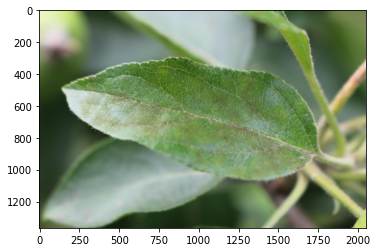

In [39]:
matplot_img('/content/Plant_Pathology/images/Train_7.jpg')

In [40]:
# class PlantDataset(Dataset):
#   def __init__(self, csv, transform):
#     super().__init__()
#     self.data = csv  #train_path
#     self.transform = transform
#     self.labels = self.data.drop(['image_id', 'image_path'], axis=1)
  
#   def __len__(self):
#     return len(self.img_path)

#   def __getitem__(self, i):
#     image = matplot_img([ip for ip in self.data['image_path']])
#     image = self.transform(image)
#     return image

class PlantDataset(Dataset):
  def __init__(self, data, path, transform=None):
    self.data = data
    self.data_dir = data_dir
    self.transform = transform
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.path, self.df.iloc[idx, -1])
    image = Image.open(img_name)
    label = self.data_frame.iloc[idx, -1]
    if self.transform:
      image = self.transform(image)
    return (image, label)

In [41]:
img_size = 1080
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = PlantDataset(train, train_path, T.Compose([
                                # T.Resize(img_size), 
                                # T.Pad(24, padding_mode='reflect'),
                                # # T.RandomPerspective(distortion_scale=0.6, p=1.0),
                                # T.RandomRotation(degrees=(0, 180)),
                                # T.RandomCrop(img_size), 
                                # T.ToTensor(), 
                                # T.Normalize(*imagenet_stats)
                                T.RandomResizedCrop(224),
                                T.RandomHorizontalFlip(),
                                T.ToTensor(),
                                T.Normalize(*imagenet_stats)]))

In [42]:
train.head()

,image_id,image_path,healthy,multiple_diseases,rust,scab,label,label_enc
0,Train_0,/content/Plant_Pathology/images/Train_0.jpg,0,0,0,1,scab,3
1,Train_1,/content/Plant_Pathology/images/Train_1.jpg,0,1,0,0,multiple_diseases,1
2,Train_2,/content/Plant_Pathology/images/Train_2.jpg,1,0,0,0,healthy,0
3,Train_3,/content/Plant_Pathology/images/Train_3.jpg,0,0,1,0,rust,2
4,Train_4,/content/Plant_Pathology/images/Train_4.jpg,1,0,0,0,healthy,0


In [43]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(data, i):
    # print(f'healthy: {data.healthy[i]}, #disease: {data.healthy[i]}, rust: {data.healthy[i]}, scab: {data.healthy[i]}')
    img_tensor = data['image_path'][i]
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [50]:
temp_img = dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
# plt.title(label_names[temp_lab])
plt.axis('off')
plt.show()


AttributeError: ignored

In [44]:
# show_image(dataset, 10)
matplot_img(dataset)

TypeError: ignored

In [ ]:
dataset[10]

In [ ]:
from torch.utils.data import random_split 
len(*dataset)
# val_size = int(0.1*len(dataset))
# train_ds, valid_ds = random_split(dataset, [len(dataset)-val_size, val_size])